In [1]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
random_state = 42
n_iter=10

In [2]:
df = pd.read_csv('train.csv',index_col=0)

In [3]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Baund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
870,1,3,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,NaN,S
871,0,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,NaN,S
872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S


In [4]:
y = df.Survived
X = df.drop('Survived',axis=1)

In [9]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Embarked', 'Sex', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [11]:
processed_data = preprocessor.fit_transform(X)

This is where I am going to use fancy impute on the data

In [8]:
num_folds=2
kf = KFold(n_splits=num_folds, random_state=random_state)

/Users/hul4/ohe/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [9]:
# y = df.Survived
X_train, X_test, y_train, y_test = train_test_split(processed_data, y, test_size=0.2)

In [10]:
def objective_func(params, random_state=random_state, cv=kf, x_train=X_train, y_train=y_train):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'max_features': int(params['max_features']),
              'min_samples_leaf': int(params['min_samples_leaf']),
             'min_samples_split': int(params['min_samples_split'])}
    
    # we use this params to create a classifier
    clf = RandomForestClassifier(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(clf, x_train, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()

    return score

In [11]:
%%time

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 5000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'min_samples_split': hp.quniform('min_samples_split', 1, 15, 1),
       'max_features': hp.quniform('max_features', 2, 5, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=objective_func, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

print(best)

100%|██████████| 10/10 [00:52<00:00,  5.23s/trial, best loss: -0.752563662234434]
{'max_depth': 8.0, 'max_features': 5.0, 'min_samples_leaf': 6.0, 'min_samples_split': 14.0, 'n_estimators': 2763.0}
CPU times: user 147 ms, sys: 86.4 ms, total: 234 ms
Wall time: 52.3 s


In [12]:
# # computing the score on the test set
model_hyper = RandomForestClassifier(random_state=random_state, n_estimators=int(best['n_estimators']),
                              min_samples_leaf=int(best['min_samples_leaf']),
                              max_features=int(best['max_features']),
                      max_depth=int(best['max_depth']),min_samples_split=int(best['min_samples_split']))
model_hyper.fit(X_train,y_train)
print("model score: %.3f" % model_hyper.score(X_test, y_test))

model score: 0.794


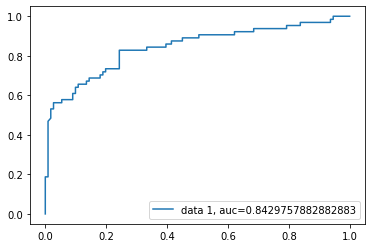

In [17]:
y_pred_proba = model_hyper.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [18]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [4,80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000,5000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = num_folds, n_jobs = -1, verbose = 2)

In [19]:
%%time

grid_search.fit(X_train,y_train)
grid_search.best_params_

Fitting 2 folds for each of 450 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  8.8min finished


CPU times: user 4.55 s, sys: 210 ms, total: 4.76 s
Wall time: 8min 45s


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [20]:

model_grid = RandomForestClassifier(random_state=random_state,bootstrap=grid_search.best_params_['bootstrap'],
                             max_depth=grid_search.best_params_['max_depth'],
                             max_features=grid_search.best_params_['max_features'],
                             min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                             min_samples_split=grid_search.best_params_['min_samples_split'],
                             n_estimators=grid_search.best_params_['n_estimators'])

model_grid.fit(X_train,y_train)
print("model score: %.3f" % model_grid.score(X_test, y_test))

model score: 0.783


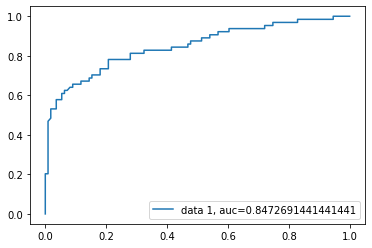

In [21]:
y_pred_proba = model_grid.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [22]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Baund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
# new_data = preprocessor.transform(df[['Age', 'Fare','Embarked', 'Sex', 'Pclass']].head(1))
new_data = df.head(1).copy()


In [24]:
new_data.Pclass = 6

In [25]:
new_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,6,"Baund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [26]:
model_hyper.predict(preprocessor.transform(new_data[X.columns]))

array([0])

In [27]:
model_grid.predict(preprocessor.transform(new_data[X.columns]))

array([0])